In [26]:
import sys

sys.path.insert(0, '../')
import utils.common as cm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [27]:
# pip install xgboost

In [28]:
# pip install scikit-learn

In [29]:
df = cm.get_dataframe()
df.head()

,year,brand,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_city_Lkm,fuel_hwy_Lkm,fuel_comb_Lkm,fuel_comb_mpg,co2
0,2002,FORD,FOCUS SEDAN #,COMPACT,2.0,4,A4,X,9.1,6.8,8.1,35,186
1,2021,Porsche,Panamera Turbo S,Full-size,4.0,8,AM8,Z,15.3,11.2,13.5,21,326
2,2011,INFINITI,EX35 AWD,STATION WAGON - SMALL,3.5,6,AS7,Z,12.4,8.5,10.6,27,244
3,2005,BUICK,RENDEZVOUS AWD,SUV,3.4,6,A4,X,12.7,8.7,10.9,26,251
4,2016,ROLLS-ROYCE,GHOST EWB,FULL-SIZE,6.6,12,AS8,Z,19.2,12.4,16.1,18,373


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18044 entries, 0 to 18043
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           18044 non-null  int64  
 1   brand          18044 non-null  object 
 2   model          18044 non-null  object 
 3   vehicle_class  18044 non-null  object 
 4   engine_size    18044 non-null  float64
 5   cylinders      18044 non-null  int64  
 6   transmission   18044 non-null  object 
 7   fuel_type      18044 non-null  object 
 8   fuel_city_Lkm  18044 non-null  float64
 9   fuel_hwy_Lkm   18044 non-null  float64
 10  fuel_comb_Lkm  18044 non-null  float64
 11  fuel_comb_mpg  18044 non-null  int64  
 12  co2            18044 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1.8+ MB


In [31]:
features_num = list(df.columns[df.dtypes != "object"])
features_num

['year',
 'engine_size',
 'cylinders',
 'fuel_city_Lkm',
 'fuel_hwy_Lkm',
 'fuel_comb_Lkm',
 'fuel_comb_mpg',
 'co2']

In [32]:
features_transform = features_num.copy()
features_transform.remove("cylinders")

features_transform

['year',
 'engine_size',
 'fuel_city_Lkm',
 'fuel_hwy_Lkm',
 'fuel_comb_Lkm',
 'fuel_comb_mpg',
 'co2']

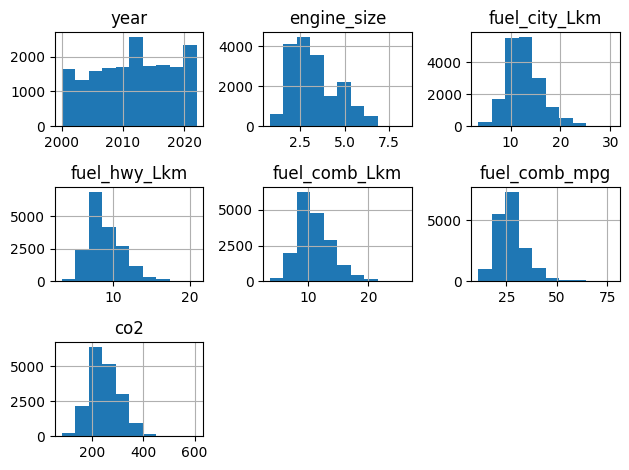

In [33]:
df[features_transform].hist()
plt.tight_layout()

In [34]:
target = "fuel_comb_mpg"

In [35]:
features_log = features_transform.copy()
features_log.remove("year")
features_log.remove(target)

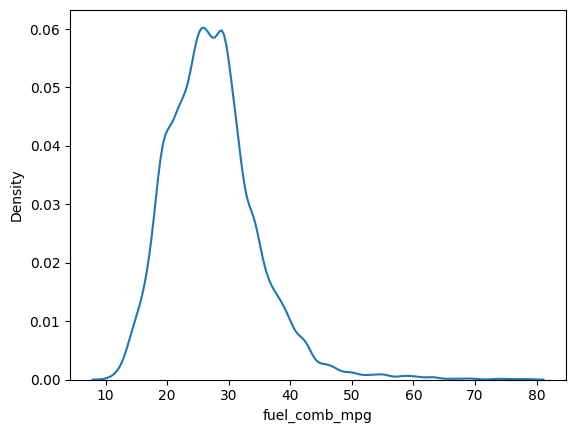

In [36]:
sns.kdeplot(df[target]);

In [37]:
df["cylinders"] = df["cylinders"].astype("object")

In [38]:
df.shape

(18044, 13)

#**Apunte 2:** la variable model tiene demasiados datos para hacer onehotencoder. Igual podriamos eliminarla y quedarnos solo con brand?

In [39]:
df["model"].value_counts()


model
JETTA                    72
MUSTANG                  65
SILVERADO                50
ALTIMA                   49
RANGER                   49
                         ..
V70 R AWD WAGON TURBO     1
G37X AWD COUPE            1
RAV4 LIMITED/SE AWD       1
NAVIGATOR 4X4 #           1
R 320 CDI                 1
Name: count, Length: 3995, dtype: int64

In [40]:
#train = train.drop("model", axis=1)

In [41]:
#Selección categoricas 
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['brand', 'model', 'vehicle_class', 'cylinders', 'transmission',
       'fuel_type'],
      dtype='object')


In [42]:
#Hay valores repetidos pero escritos diferente.Normalizamos:

df[categorical_cols] = df[categorical_cols].apply(lambda x: x.astype(str).str.lower())

In [43]:


# Pipeline categoricas
cat_pipeline = Pipeline([
    ("Impute_Mode", SimpleImputer(strategy="most_frequent")),  # metemos la moda 
    ("OHEncoder", OneHotEncoder(handle_unknown="ignore"))      
])
# Transformación logarítmica
log_transformer = FunctionTransformer(lambda x: np.log(x + 1))  # Sumar 1 para evitar log(0)

# Pipeline para transformación logarítmica y escalado de las numericas
num_pipeline = Pipeline([
    ("log", log_transformer),
    ("scaler", MinMaxScaler()) 
])


preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, categorical_cols),
        ("log_and_scaler", num_pipeline, features_log), 
        ("scaler_only", MinMaxScaler(), ["year"]),
        ("exclude", "drop", target )
]) 

# train_categorical = df[categorical_cols]

# train_processed = preprocessing.fit_transform(train_categorical)

train = preprocessing.fit_transform(df)
print(train.shape)


#nombres de las nuevas columnas
# encoded_cols = preprocessing.transformers_[0][1].named_steps['OHEncoder'].get_feature_names_out(categorical_cols)

# train_processed_dense = train_processed.toarray()

# X_train_processed_df = pd.DataFrame(train_processed_dense, columns=encoded_cols)

# X_train_processed_df.head()

(18044, 3654)


In [44]:
# # Transformación logarítmica
# log_transformer = FunctionTransformer(lambda x: np.log(x + 1))  # Sumar 1 para evitar log(0)

# # Pipeline para transformación logarítmica y escalado
# num_pipeline = Pipeline([
#     ("log", log_transformer),
#     ("scaler", MinMaxScaler()) 
# ])

# # Preprocesador con todas las transformaciones
# preprocessing_pipeline = ColumnTransformer([
#     ("log_and_scaler", num_pipeline, features_log), 
#     ("scaler_only", MinMaxScaler(), ["year"]),
# ])
# # ("ohe", OneHotEncoder(handle_unknown = "ignore"), ["cylinders"])  # OneHotEncoding

# # Aplicar las transformaciones
# train = preprocessing_pipeline.fit_transform(df)
# pd.DataFrame(train)

In [46]:

# Pipeline para Linear Regression
lr_pipeline = Pipeline([
    ('Premodelado', preprocessing),   
    ('ModeloRegressor', LinearRegression())
])

# Pipeline para Random Forest
rf_pipeline = Pipeline([
    ('Premodelado', preprocessing),
    ('ModeloRegressor', RandomForestRegressor(random_state=42))
])

# Pipeline para XGBoost
xgb_pipeline = Pipeline([
    ('Premodelado', preprocessing),
    ('ModeloRegressor', xgb.XGBRegressor(random_state=42))
])



In [50]:
y_train = np.log(df[target]+1).to_numpy()

In [54]:
y_train.shape

(18044,)

In [53]:
train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 216010 stored elements and shape (18044, 3654)>

In [58]:
cv= 5

#se aplica la validacion cruzada a cada modelo 
#scoring utilizo la raiz del error cuadratico medio
for name, pipe in zip(["lr_pipeline","rf_pipeline", "xgb_pipeline"],[lr_pipeline, rf_pipeline, xgb_pipeline]):
    resultado = cross_val_score(pipe, df, y_train, cv = cv, scoring = "neg_root_mean_squared_error")
    print(f"{name}: {-np.mean(resultado):.4f}")
    print(resultado)

lr_pipeline: 0.0118
[-0.01164344 -0.01167042 -0.01165193 -0.01200636 -0.01198041]
rf_pipeline: 0.0007
[-0.00036543 -0.00089422 -0.00076428 -0.00028062 -0.00126254]
xgb_pipeline: 0.0009
[-0.00063021 -0.00074102 -0.00084555 -0.00136103 -0.00116514]


In [ ]:
# Linear Regression
lr_params = {
    'ModeloRegressor__fit_intercept': [True, False], # si tiene o no intercept
    'ModeloRegressor__normalize' :  [True, False]  # normaliza, aunque puede ser redundante si ya se han prpcesado correctamente los datos
}

lr_grid = GridSearchCV(
    lr_pipeline, 
    lr_params, 
    cv=cv, 
    scoring='neg_root_mean_square_error',
    verbose=1,
    n_jobs=-1
)

# Random Forest GridSearchCV
rf_params = {
    'ModeloRegressor__n_estimators': [50, 100, 200],
    'ModeloRegressor__max_depth': [None, 10, 20, 50],
    'ModeloRegressor__min_samples_split': [2, 5],
    # 'ModeloRegressor__bootstrap': [True, False] #`bootstrap`: Puede ser interesante probar tanto True como False  
}

rf_grid = GridSearchCV(
    rf_pipeline, 
    rf_params, 
    cv=cv, 
    scoring='neg_root_mean_square_error',
    verbose=1,
    n_jobs=-1
)



# XGBoost GridSearchCV
xgb_params = {
    'ModeloRegressor__n_estimators': [50, 100, 200],
    'ModeloRegressor__learning_rate': [0.05, 0.1],
    'ModeloRegressor__max_depth': [3, 5, 10],
    'ModeloRegressor__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, 
    xgb_params, 
    cv=cv, 
    scoring='neg_root_mean_square_error',
    verbose=1,
    n_jobs=-1
)


pipe_grids = {"gs_lr":lr_grid,
         "gs_rand_forest":rf_grid,
         "gs_xgb":xgb_grid}
